In [137]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt

from ReadMaestro import maestro
from ReadMaestro import parse_pursuit_trials
paths = [p for p in sys.path if os.path.exists(p)]
print(paths)

from importlib import reload
reload(maestro)
reload(parse_pursuit_trials)

['/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/home/seth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


<module 'ReadMaestro.parse_pursuit_trials' from '/home/seth/analysis/ReadMaestro/ReadMaestro/parse_pursuit_trials.py'>

In [2]:
file_path = '/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a/ar220404a.0001'
with open(file_path, 'rb') as f:
    data_file = maestro.DataFile.load(f.read(), file_path)

In [76]:
data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a')

In [143]:
purs = parse_pursuit_trials.pursuitDataObject
purs.__init__(purs)
purs.setName(purs,data)
print(purs.name)

purs.pursuitData(purs,data,trialIDs=['dPref'], directions=[0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0], speeds=[10.0], coherences=[], perturbations=[]);
purs.applyRotationToData(purs)
purs.setSaccadeVelocitiesToNaN(purs)

/home/seth/Projects/DynamicCoherencePhysiology/ar/2022040


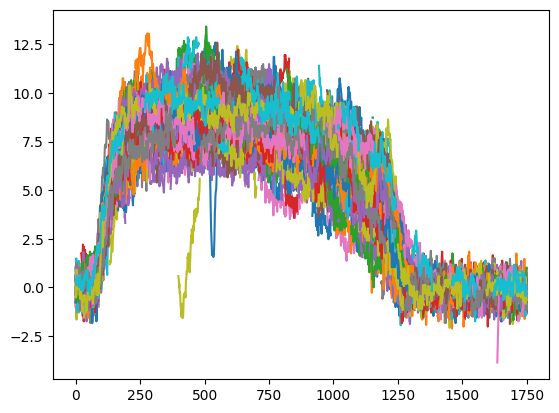

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(purs.hvelocities);

In [94]:
print(purs.hvelocities.shape)
print(len(purs.directions))
purs.hvelocities*np.cos(np.deg2rad(purs.directions))

(1751, 20)
20


array([[-1.10268,  2.20536, -0.73512, ..., -0.27567, -1.56213, -0.     ],
       [-0.82701,  2.11347, -0.82701, ..., -0.36756, -1.37835, -0.09189],
       [-0.09189,  2.20536, -0.36756, ..., -0.45945, -1.19457, -0.     ],
       ...,
       [ 0.     ,  0.45945, -1.47024, ..., -0.9189 ,  0.09189, -0.64323],
       [ 0.09189, -0.     , -2.20536, ..., -0.82701, -0.09189, -0.55134],
       [ 0.64323, -0.18378, -3.6756 , ..., -0.9189 , -0.09189, -0.36756]])

In [100]:
a = np.array([[1, 2, 3],[4, 5, 6]])
b = [1, 2]
print(a*b)

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

In [69]:
a = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0],[10.0,11.0,12.0]])
print(a)
b = np.diff(a,axis=0,prepend=0)
filt = np.ones((2,))/2
d = np.add(b>2,b<2)
c = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=(d))
print(c)
print(d)
e = np.full_like(a, False)
e[c>0] = True
print(e)

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]
[[0.5 0.  0.5]
 [1.  0.5 1. ]
 [1.  1.  1. ]
 [1.  1.  1. ]]
[[ True False  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[1. 0. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
